In [1]:
import sys
from pathlib import Path

if str(Path().resolve() / "src") not in sys.path:
    sys.path.append(str(Path().resolve() / "src"))

# Data Preprocessing

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from src.config import random_seed, DATASET_PATH

# Import data
data = pd.read_csv(DATASET_PATH)

# Correcting URL of the paper if needed
data["url_paper"] = data["url_paper"].str.replace("abs", "pdf", regex=False)

# Calculate engagement score
data["engagement_score"] = (data["claps"] + 3 * data["comments"]) / data["author_followers"]
min_val = data["engagement_score"].min()
max_val = data["engagement_score"].nlargest(3).iloc[-1] # Ignore 2 outliers
data["normalized_engagement_score"] = 100 * (data["engagement_score"] - min_val) / (max_val - min_val) # Experimental MinMax normalization
data["normalized_engagement_score"] = round(data["normalized_engagement_score"].clip(1, 100))

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    data.drop(columns=['normalized_engagement_score']), data["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 10), y: (30,)
Size of test set, X: (20, 10), y: (20,)


In [3]:
# The best blog in dataset
best_blog_info = Xval.sort_values(["engagement_score"], ascending=False).head(1)
best_blog_index = best_blog_info.index[0]
best_blog_info = best_blog_info.reset_index(drop=True)
best_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score
0,28,Towards Reasoning,https://medium.com/@saptarshichaudhuri/towards...,Saptarshi Chaudhuri,127,461,1,GSM-Symbolic: Understanding the Limitations of...,https://arxiv.org/pdf/2410.05229?source=post_p...,3.653543


In [4]:
# The worst blog in dataset
worst_blog_info = Xval.sort_values(["engagement_score"], ascending=False).tail(1)
worst_blog_index = worst_blog_info.index[0]
worst_blog_info = worst_blog_info.reset_index(drop=True)
worst_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,title_paper,url_paper,engagement_score
0,18,SMoA: Improving Multi-agent Large Language Mod...,https://medium.com/@sulbha.jindal/smoa-improvi...,Sulbha Jain,41,0,0,SMoA: Improving Multi-agent Large Language Mod...,https://arxiv.org/pdf/2411.03284,0.0


In [5]:
blog = data.iloc[16]
blog

id                                                                            17
title_blog                     Self-Generated Critiques Boost Reward Modeling...
url_blog                       https://medium.com/@sulbha.jindal/self-generat...
author_blog                                                          Sulbha Jain
author_followers                                                              41
claps                                                                         21
comments                                                                       0
title_paper                    Self-Generated Critiques Boost Reward Modeling...
url_paper                                       https://arxiv.org/pdf/2411.16646
engagement_score                                                        0.512195
normalized_engagement_score                                                 49.0
Name: 16, dtype: object

In [6]:
from src.text_extraction import extract_blog_text

# Extracting clean text from a blog
blog_text = extract_blog_text(blog)
print(blog_text)

# Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Paper — https://arxiv.org/pdf/2411.16646
Reinforcement Learning from Human Feedback (RLHF) has become a critical methodology for aligning large language models (LLMs) with human preferences. At the core of RLHF lies the reward model (RM), which is designed to evaluate model outputs by assigning scores that reflect their alignment with human judgments. These scores guide the optimization process during training, such as providing reward signals in Proximal Policy Optimization (PPO), thereby encouraging LLMs to generate responses that are more helpful, honest, and harmless. This iterative process enhances the practical quality of LLM outputs in real-world applications.

## Current challenge
Typically, reward models are trained using preference pairs and optimized through pairwise logistic loss to produce a scalar score for each response. However, this scalar output is often hard to interpret and underutili

In [7]:
from src.text_extraction import extract_paper_text

# Extracting clean text from a scientific paper
paper_url = data["url_paper"][16]
paper_text = extract_paper_text(paper_url)
print(paper_text)

Error: [Errno 2] No such file or directory: 'tmp/temp_paper.pdf'


# API Tests

In [8]:
from dotenv import load_dotenv
import os

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [10]:
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)

available_models = [model.name for model in genai.list_models()]
print(f"Available models: {available_models}\n")
if "models/gemini-2.0-flash" in available_models:
    print("Gemini 2.0 Flash is available via API request!")
else:
    print("Gemini 2.0 Flash is not available via API request!")

Available models: ['models/chat-bison-001', 'models/text-bison-001', 'models/embedding-gecko-001', 'models/gemini-1.0-pro-vision-latest', 'models/gemini-pro-vision', 'models/gemini-1.5-pro-latest', 'models/gemini-1.5-pro-001', 'models/gemini-1.5-pro-002', 'models/gemini-1.5-pro', 'models/gemini-1.5-flash-latest', 'models/gemini-1.5-flash-001', 'models/gemini-1.5-flash-001-tuning', 'models/gemini-1.5-flash', 'models/gemini-1.5-flash-002', 'models/gemini-1.5-flash-8b', 'models/gemini-1.5-flash-8b-001', 'models/gemini-1.5-flash-8b-latest', 'models/gemini-1.5-flash-8b-exp-0827', 'models/gemini-1.5-flash-8b-exp-0924', 'models/gemini-2.0-flash-exp', 'models/gemini-2.0-flash', 'models/gemini-2.0-flash-001', 'models/gemini-2.0-flash-lite-001', 'models/gemini-2.0-flash-lite', 'models/gemini-2.0-flash-lite-preview-02-05', 'models/gemini-2.0-flash-lite-preview', 'models/gemini-2.0-pro-exp', 'models/gemini-2.0-pro-exp-02-05', 'models/gemini-exp-1206', 'models/gemini-2.0-flash-thinking-exp-01-21', 

In [11]:
# Check API request
gemini = genai.GenerativeModel("models/gemini-2.0-flash")
check_response = gemini.generate_content("If you receive this request, please say Hello.")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 10
candidates_token_count: 3
total_token_count: 13

Content:
Hello.



In [12]:
# Checking if the model can get to the blog through the URL
check_response = gemini.generate_content(f"make a summary of this blog in 100 words\n\n{blog.url_blog}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 60
candidates_token_count: 109
total_token_count: 169

Content:
Sulbha Jindal's blog post summarizes a research paper exploring self-generated critiques in reward modeling for language models. Instead of relying on human feedback for training reward models, the authors propose using language models to critique their own outputs. This self-critiquing approach, which involves generating a response and then a critique of that response, significantly improves the alignment between the model's objectives and human preferences. The paper demonstrates that this method rivals the performance of models trained with human feedback while offering a more scalable and cost-effective alternative.



In [13]:
# Passing clean text to the model
check_response = gemini.generate_content(f"make a summary of this blog in 100 words\n\n{blog_text}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 1138
candidates_token_count: 124
total_token_count: 1262

Content:
Critic-RM is a new framework for enhancing reward models in LLMs using self-generated critiques, addressing limitations of traditional scalar reward outputs. It leverages instruction-tuned LLMs to generate multiple critiques, filtering them based on consistency with human preferences. Summarization and ranking further refine the critiques used for training. A balanced training strategy prioritizes critique modeling initially, then shifts to reward prediction using both responses and critiques. Experiments show Critic-RM outperforms standard models, with the quality of critiques playing a crucial role. The approach has demonstrated robust performance across RewardBench and CrossEval, showing improved alignment with human preferences.



In [14]:
# Checking ability to read PDF
check_response = gemini.generate_content(f"Create a table of contents for this publication.\n{paper_url}")
print(f"Usage metadata:\n{check_response.usage_metadata}")
print(f"Content:\n{check_response.candidates[0].content.parts[0].text}")

Usage metadata:
prompt_token_count: 28
candidates_token_count: 1016
total_token_count: 1044

Content:
Okay, based on the provided arXiv link (https://arxiv.org/pdf/2411.16646), I can create a likely Table of Contents for the document, titled "Advancing Medical Diagnosis and Precision Medicine through Federated Learning".  Please note that without having the actual PDF text to confirm, I'm inferring this based on standard practices for academic papers, especially in the field of machine learning and medical imaging.

**Table of Contents**

**1. Introduction**
    *   1.1 Motivation: The Promise of Federated Learning in Healthcare
    *   1.2 Challenges in Medical Data Sharing
    *   1.3 Federated Learning: A Collaborative Approach
    *   1.4 Contributions of This Work
    *   1.5 Organization of the Paper

**2. Background and Related Work**
    *   2.1 Medical Image Analysis and Diagnosis
    *   2.2 Precision Medicine and Personalized Treatment
    *   2.3 Federated Learning: Princip

# Prompt Engineering

In [10]:
from src.models_setup import gemini_2_flash
from src.prompts import *

def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [16]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1134, 'output_tokens': 3, 'total_tokens': 1137, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [17]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1139, 'output_tokens': 9, 'total_tokens': 1148, 'input_token_details': {'cache_read': 0}}

Content:
Informative - 8/10


In [18]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1150, 'output_tokens': 92, 'total_tokens': 1242, 'input_token_details': {'cache_read': 0}}

Content:
**Score: 78/100**

**Comment:** This blog post provides a reasonably clear and concise overview of the Critic-RM paper. It effectively summarizes the key aspects of the methodology and results. However, it lacks in-depth analysis and critical evaluation of the paper's strengths and weaknesses. Adding a section on potential limitations, alternative approaches, or future research directions would improve its overall quality and provide more value to the reader.


In [19]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1156, 'output_tokens': 109, 'total_tokens': 1265, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level Score: 55/100**

**Comment:** The blog post provides a concise and understandable overview of a research paper on reward modeling. However, it lacks elements that typically drive higher engagement. The content is primarily informational and doesn't include interactive elements like questions for readers, calls for discussion, or opportunities for the audience to share their experiences or opinions. While the technical explanation is clear, it could benefit from practical examples or real-world implications to make it more relatable and engaging for a broader audience.


In [20]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1180, 'output_tokens': 141, 'total_tokens': 1321, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level Assessment: 65/100**

**Comment:**

This blog post provides a decent overview of the Critic-RM paper. Its engagement level is moderate due to a few factors. The title is clear and concise. The structure is logical, breaking down the paper into understandable sections (Challenge, Methodology, Results, Summary). However, the writing style is somewhat technical and assumes a level of familiarity with RLHF and LLMs, which limits its appeal to a broader audience. The use of mathematical notation, while accurate, could be simplified for better readability. The post provides a good summary, but lacks strong hooks or calls to action to actively encourage discussion or further exploration.


In [21]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1201, 'output_tokens': 610, 'total_tokens': 1811, 'input_token_details': {'cache_read': 0}}

Content:
Okay, let's break down the engagement level of this blog post based on the provided criteria:

**Criterion Scores (1-100 Scale):**

*   **Readability (70/100):** The language used is generally accessible to those with a background in machine learning or NLP. However, there is use of some more technical terms (e.g., "Proximal Policy Optimization," "pairwise logistic loss") that might be difficult for those unfamiliar with this field.

*   **Structure (85/100):** The blog post follows a clear and logical structure. It starts with an introduction to the topic, outlines the challenges, explains the methodology, presents the results, and concludes with a summary. The use of headings and subheadings helps to organize the content effectively.

*   **Informativeness (90/100):** The blog post provides a good overview of the paper it is reviewing. It clearly expl

In [22]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1225, 'output_tokens': 763, 'total_tokens': 1988, 'input_token_details': {'cache_read': 0}}

Content:
Okay, let's analyze this blog post based on the provided criteria.

**Criterion Breakdown:**

*   **Readability (75/100):** The language is generally accessible to someone with some familiarity with AI/ML concepts. However, there are instances of jargon (e.g., "pairwise logistic loss," "knowledge distillation") that could be simplified or explained further for a broader audience. The use of notation $$r = r_\psi(x, [y, z])$$ might be off-putting to some readers. I find the transition words and explanations used provide context for the reader.

*   **Structure (85/100):** The blog post follows a logical structure. It starts with an introduction to RLHF and reward modeling, identifies the challenges, presents the proposed solution (Critic-RM), explains the methodology, highlights the results, and provides a summary. The use of headings and subheadings is 

In [23]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1322, 'output_tokens': 758, 'total_tokens': 2080, 'input_token_details': {'cache_read': 0}}

Content:
Here's an evaluation of the blog post, broken down by the requested criteria:

**Readability (75/100):** The writing is generally clear, but some sentences are a bit long and complex, especially in the methodology section. The use of technical terms without immediate, accessible definitions could also hinder readability for a broader audience.

**Structure (80/100):** The blog follows a logical structure: introduction, problem statement, proposed solution (methodology), results, and summary. The use of headings and subheadings is helpful. However, the transition between sections could be smoother.

**Informativeness (85/100):** The blog provides a good overview of the paper's key concepts, methodology, and findings. It explains the problem Critic-RM addresses and the benefits it offers.

**Attractiveness of the blog title (65/100):** "Self-Generated Cri

In [11]:
best_blog = {
    "blog": extract_blog_text(best_blog_info.iloc[0]),
    "score" : yval_score.loc[best_blog_index]
}
worst_blog = {
    "blog" : extract_blog_text(worst_blog_info.iloc[0]),
    "score" : yval_score.loc[worst_blog_index]
}

In [12]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 3246, 'output_tokens': 284, 'total_tokens': 3530, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_assessment": 65.0,
  "explanation": "The blog post provides a decent overview of the Critic-RM paper. It explains the background, methodology, results, and summary in a structured manner. However, the explanation of the methodology could be improved with more details and clarity, especially regarding the weighting strategy and the inference process. Also, it is not detailed enough. The title is adequate but not particularly attention-grabbing, reducing its audience appeal. There's limited potential for discussion due to the high-level overview without critical analysis or open questions. Also, there are some typos in the text.",
  "possible_improvements": [
    "Elaborate on the methodology section with more specific details about the consistency-guided filtering technique and the weighting strategy used for integrating critique mod

# Performance testing on a validation set

In [14]:
from src.models_setup import BlogEvaluation, BlogClassification
from src.helpers import extract_llm_assessment

gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation)
llm_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                        {
                                            "blog_ex1" : best_blog["blog"],
                                            "score_ex1" : best_blog["score"],
                                            "blog_ex2" : worst_blog["blog"],
                                            "score_ex2" : worst_blog["score"]
                                        })

----------
Blog ID: 35
Blog title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
Referenced paper title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
LLM Assessment: 65.0

----------
Blog ID: 21
Blog title: Reflections on Innateness in Machine Learning
Referenced paper title: Innateness, AlphaZero, and Artificial Intelligence
LLM Assessment: 75.0

----------
Blog ID: 31
Blog title: How reinforcement learning affects human behavior?
Referenced paper title: Acquisition of Chess Knowledge in AlphaZero
LLM Assessment: 65.0

----------
Blog ID: 20
Blog title: ChatGPT vs Bing … and the urgent need for Responsible AI
Referenced paper title: Adaptive Test Generation Using a Large Language Model
LLM Assessment: 65.0

----------
Blog ID: 48
Blog title: Data Centric AI — LLAVA
Referenced paper title: Visual Instruction Tuning
LLM Assessment: 55.0

----------
Blog ID: 18
Blog title: SMoA:

In [15]:
from sklearn import metrics

RMSE_val = metrics.root_mean_squared_error(yval_score, llm_assessment)
print(f"Root Mean Square Error on validation set: {RMSE_val:.1f}")
MAE_val = metrics.mean_absolute_error(yval_score, llm_assessment)
print(f"Mean Absolute Error on validation set: {MAE_val:.1f}")

Root Mean Square Error on validation set: 41.6
Mean Absolute Error on validation set: 33.4


In [16]:
from sklearn.preprocessing import MinMaxScaler

llm_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
scaled_llm_assessment = llm_assessment_scaler.fit_transform(llm_assessment.values.reshape(-1, 1))
RMSE_val_scaled = metrics.root_mean_squared_error(yval_score, scaled_llm_assessment)
print(f"Root Mean Square Error on validation set after MinMax normalization of LLM output: {RMSE_val_scaled:.1f}")
MAE_val_scaled = metrics.mean_absolute_error(yval_score, scaled_llm_assessment)
print(f"Mean Absolute Error on validation set after MinMax normalization of LLM output: {MAE_val_scaled:.1f}")

Root Mean Square Error on validation set after MinMax normalization of LLM output: 42.4
Mean Absolute Error on validation set after MinMax normalization of LLM output: 33.7


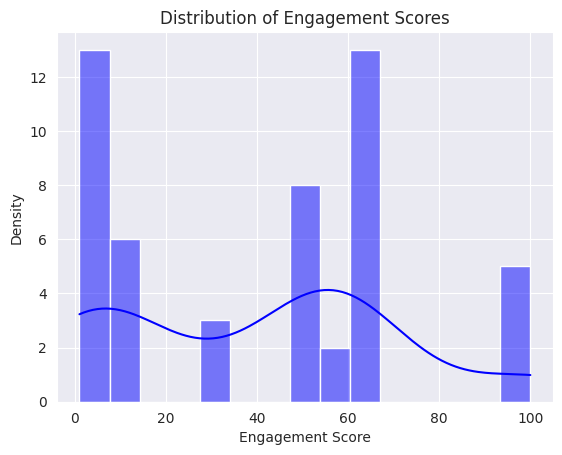

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data["normalized_engagement_score"], bins=15, kde=True, color="blue")
plt.xlabel("Engagement Score")
plt.ylabel("Density")
plt.title("Distribution of Engagement Scores")
plt.show()

In [22]:
def classify_blog(score):
    """Return blog classification based on engagement score."""
    if score >= 80:
        return "Excellent"
    elif score >= 60:
        return "Very Good"
    elif score >= 40:
        return "Good"
    elif score >= 20:
        return "Average"
    else:
        return "Bad"
data["engagement_level"] = data["normalized_engagement_score"].apply(classify_blog)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    data.drop(columns=['engagement_level', 'normalized_engagement_score']), data["engagement_level"],
    test_size=0.4, random_state=random_seed)

In [24]:
def print_evaluation(blog_evaluation: BlogEvaluation):
    print(f"Blog Title: {blog_evaluation.blog_title}")
    print(f"Overall Assessment: {blog_evaluation.overall_assessment}")
    print(f"Explanation: {blog_evaluation.assessment_explanation}")
    print("Suggested Improvements:")
    for i, improvement in enumerate(blog_evaluation.improvements, start=1):
        print(f"\t{i}. {improvement}")

gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification)

In [25]:
excellent_blog_index = yval_level[yval_level == "Excellent"].index.min()
excellent_blog = extract_blog_text(Xval.loc[excellent_blog_index])
very_good_blog_index = yval_level[yval_level == "Very Good"].index.min()
very_good_blog = extract_blog_text(Xval.loc[very_good_blog_index])
good_blog_index = yval_level[yval_level == "Good"].index.min()
good_blog = extract_blog_text(Xval.loc[good_blog_index])
average_blog_index = yval_level[yval_level == "Average"].index.min()
average_blog = extract_blog_text(Xval.loc[average_blog_index])
bad_blog_index = yval_level[yval_level == "Bad"].index.min()
bad_blog = extract_blog_text(Xval.loc[bad_blog_index])

In [28]:
# 5-shot prompt with verbal classification
chain = prompt_five_shots | gemini_2_flash_structured
response = chain.invoke({
    "blog_text" : blog_text,
    "excellent_blog" : excellent_blog,
    "very_good_blog" : very_good_blog,
    "good_blog" : good_blog,
    "average_blog" : average_blog,
    "bad_blog" : bad_blog
})
print_evaluation(response)

Blog Title: Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review
Overall Assessment: Average
Explanation: The blog post provides a concise overview of the Critic-RM framework, a novel approach to enhance reward modeling for large language models (LLMs). While it covers the key aspects of the paper, including the methodology, results, and summary, it lacks depth and critical analysis. The title is adequate but not particularly engaging. The structure is logical, but the content is somewhat superficial. The blog post could benefit from a more detailed explanation of the technical concepts, a more critical discussion of the results, and a more engaging writing style. Additionally, it does not specify any particular audience that the blog is meant for. Due to the lack of deep dives into the subject matter, the assessment is 'Average'.
Suggested Improvements:
	1. Provide more in-depth explanations of the technical concepts.
	2. Offer a critical analysis of the re

In [32]:
llm_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                            examples=
                                            {
                                                "excellent_blog" : excellent_blog,
                                                "very_good_blog" : very_good_blog,
                                                "good_blog" : good_blog,
                                                "average_blog" : average_blog,
                                                "bad_blog" : bad_blog
                                            })

----------
Blog ID: 35
Blog title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
Referenced paper title: The Landscape of Emerging AI Agent Architectures for Reasoning, Planning, and Tool Calling: A Survey
LLM Assessment: Good

----------
Blog ID: 21
Blog title: Reflections on Innateness in Machine Learning
Referenced paper title: Innateness, AlphaZero, and Artificial Intelligence
LLM Assessment: Average

----------
Blog ID: 31
Blog title: How reinforcement learning affects human behavior?
Referenced paper title: Acquisition of Chess Knowledge in AlphaZero
LLM Assessment: Average

----------
Blog ID: 20
Blog title: ChatGPT vs Bing … and the urgent need for Responsible AI
Referenced paper title: Adaptive Test Generation Using a Large Language Model
LLM Assessment: Good

----------
Blog ID: 48
Blog title: Data Centric AI — LLAVA
Referenced paper title: Visual Instruction Tuning
LLM Assessment: Average

----------
Blog ID: 18
Blog tit

In [33]:
prediction_accuracy = metrics.accuracy_score(yval_level, llm_classification)
print(f"Accuracy score on validation set: {prediction_accuracy * 100:.2f}%")

Accuracy score on validation set: 53.33%


In [34]:
level_map = {
    "Excellent" : 5,
    "Very Good" : 4,
    "Good" : 3,
    "Average" : 2,
    "Bad" : 1
}
RMSE_val_verbal = metrics.root_mean_squared_error(yval_level.map(level_map), llm_classification.map(level_map))
MAE_val_verbal = metrics.mean_absolute_error(yval_level.map(level_map), llm_classification.map(level_map))
print(f"Root Mean Square Error on validation set after using the verbal classification: {RMSE_val_verbal:.1f}")
print(f"Mean Absolute Error on validation set after using verbal classification: {MAE_val_verbal:.1f}")

Root Mean Square Error on validation set after using the verbal classification: 1.3
Mean Absolute Error on validation set after using verbal classification: 0.8
